<a href="https://colab.research.google.com/github/Alf-caput/LAB03_Clasificacion/blob/Adev/LAB03_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/Alf-caput/LAB03_Clasificacion/raw/main/Recursos%20Lab3.zip

--2024-04-17 23:57:50--  https://github.com/Alf-caput/LAB03_Clasificacion/raw/main/Recursos%20Lab3.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alf-caput/LAB03_Clasificacion/main/Recursos%20Lab3.zip [following]
--2024-04-17 23:57:50--  https://raw.githubusercontent.com/Alf-caput/LAB03_Clasificacion/main/Recursos%20Lab3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66844615 (64M) [application/zip]
Saving to: ‘Recursos Lab3.zip’

Recursos Lab3.zip   100%[===================>]  63.75M   209MB/s    in 0.3s    

2024-04-17 23:57:50 (209 MB/s) - ‘Recursos Lab3.zip’ saved [66844615/6684461

Descomprimimos el archivo zip que contiene los datasets

In [2]:
from zipfile import ZipFile
import os

zip_filename = 'Recursos Lab3.zip'
base_dir = os.path.splitext(zip_filename)[0] + '/'

if not os.path.exists(base_dir):
    with ZipFile(zip_filename, 'r') as zf:
        for file in zf.namelist():
            if file.startswith(base_dir):
                zf.extract(file)

Descomprimimos la carpeta comprimida Malware.zip

In [3]:
import os
import zipfile

zip_filename = 'Malware.zip'
output_dir = os.path.splitext(zip_filename)[0] + '/'
output_dir = os.path.join(base_dir, output_dir)

if not os.path.exists(output_dir):
    with zipfile.ZipFile(os.path.join(base_dir, zip_filename)) as zf:
        zf.extractall(path=base_dir)

Con opencv-python convertimos las imágenes a numpy arrays.  
Para almacenar las imágenes creamos un diccionario que lleva por claves las 4 posibles clases y como valores listas que contienen los numpy arrays.

Adicionalmente comprobamos los tamaños de las imágenes, nadie nos garantiza que todas o dentro de cada carpeta se tenga un único tamaño.  
Utilizamos set() para detectar los diferentes tamaños únicos existentes.

In [4]:
import cv2

labels = os.listdir(output_dir)
data = dict()
shapes = dict()

for label in labels:

    class_dir = os.path.join(output_dir, label)

    data[label] = []
    shapes[label] = []

    for image in os.listdir(class_dir):

        image = cv2.imread(os.path.join(class_dir, image), cv2.IMREAD_GRAYSCALE)

        data[label].append(image)
        shapes[label].append(image.shape)

    shapes[label] = list(set(shapes[label]))

data[labels[0]][0], shapes[labels[0]]

(array([[ 77,  90, 144, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,  51, 202,  51],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 [(277, 384),
  (278, 384),
  (273, 384),
  (349, 384),
  (285, 384),
  (416, 384),
  (288, 384),
  (345, 384),
  (280, 384),
  (282, 384)])

Se observa que tienen dimensiones distintas, tanto fuera como dentro de una misma clase, tomaremos como dimensiones estándar las menores existentes (de manera independiente la menor X y la menor Y)

In [5]:
min_dim = dict()
for label in labels:
    min_dim[label] = shapes[label][0]  # start with shape[0] as min
    for shape in shapes[label][1:]:
        min_dim[label] = min(min_dim[label][0], shape[0]), min(min_dim[label][1], shape[1])

std_dim = min(min_dim.values())
std_dim

(208, 64)

A continuación, se redimensionan las imágenes a la dimensión estándar

In [6]:
for label in labels:
    for i, image in enumerate(data[label]):
        data[label][i] = cv2.resize(image, std_dim[::-1]) # due to cv2.resize use (width, height) we reverse dimensions

Podemos comprobar que la redimensión ha tenido éxito stackeando los numpy arrays por etiqueta, que además es un formato más conveniente cuando se trabaja con tensores

In [7]:
import numpy as np
from copy import deepcopy

ds = deepcopy(data)

for label in labels:
    ds[label] = np.stack(data[label])
    print(label, ds[label].shape)

Fakerean (59, 208, 64)
Yuner.A (173, 208, 64)
Agent.FYI (66, 208, 64)
Lolyda.AA1 (167, 208, 64)


Podemos ver un ejemplo de cada clase

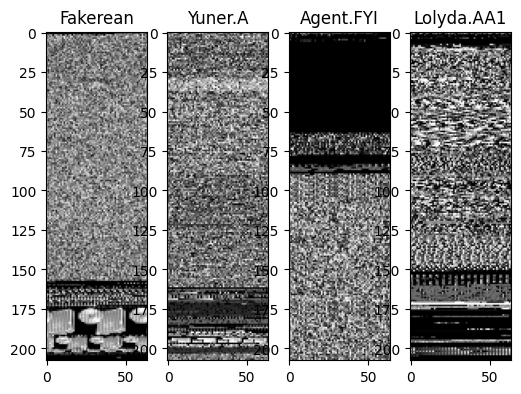

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(6, 6))

for idx, label in enumerate(data):
    axs[idx].imshow(ds[label][0], cmap='gray')
    axs[idx].set_title(label)

plt.show()

Definimos dos tensores:  
- Imágenes (X)
- Etiquetas (y)

In [9]:
import numpy as np

X = np.array([x for label in labels for x in ds[label]])
y = np.array([labels.index(label) for label in labels for idx in range(len(ds[label]))])

X.shape, y.shape

((465, 208, 64), (465,))

En total contamos con 465 imágenes de dimensiones (height, width) = (208, 64) y 465 etiquetas de dimensión ()

Dividimos en datos de train y test, adicionalemte utilizamos namedtuples por legibilidad

In [10]:
from sklearn.model_selection import train_test_split
from collections import namedtuple

seed = 42
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_ratio, shuffle=True)

Dataset = namedtuple('Dataset', ['X', 'y'])

ds_train = Dataset(X_train, y_train)
ds_test = Dataset(X_test, y_test)

print("Train:", ds_train.X.shape, ds_train.y.shape)
print("Test:", ds_test.X.shape, ds_test.y.shape)

Train: (372, 208, 64) (372,)
Test: (93, 208, 64) (93,)


In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

num, height, width = ds_train.X.shape
X_train_input = ds_train.X.reshape(num, height * width)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_input, ds_train.y)

num, height, width = ds_test.X.shape
X_test_input = ds_test.X.reshape(num, height * width)

y_pred = clf.predict(X_test_input)
y_pred

array([0, 1, 0, 3, 2, 1, 3, 0, 3, 2, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 3,
       0, 3, 1, 2, 3, 3, 0, 1, 2, 3, 1, 3, 3, 0, 1, 3, 2, 3, 1, 1, 1, 1,
       3, 1, 3, 2, 3, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3,
       3, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 3, 1, 3, 0, 3, 1, 1, 0, 3, 2, 1,
       1, 3, 3, 0, 3])

In [13]:
from sklearn.metrics import accuracy_score

y_true = ds_test.y
accuracy_score(y_true, y_pred)

0.989247311827957

array([[ 61,   2,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  19,  34,  85],
       [110,  63, 167, ..., 104, 109, 103],
       ...,
       [  0, 166, 142, ...,  29,  29,  38],
       [ 88, 149, 163, ..., 145, 151, 151],
       [ 26,  34,  29, ...,  26,  26,  21]], dtype=uint8)
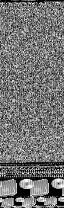

In [14]:
ds_test.X[0]